연속형 변수: ['총주차면', '경도', '위도', '1시간 요금']
범주형 변수: ['주차장종류', '평일유료', '토요일유료', '공휴일유료', '평일시작', '평일종료', '토요일시작', '토요일종료', '공휴일시작', '공휴일종료', '기본주차시간', '추가단위시간']

■ Pearson
                   총주차면     경도     위도  1시간 요금  complaint_count
총주차면             1.000  0.048  0.055   0.032            0.095
경도               0.048  1.000  0.223   0.143            0.004
위도               0.055  0.223  1.000   0.109            0.043
1시간 요금           0.032  0.143  0.109   1.000            0.090
complaint_count  0.095  0.004  0.043   0.090            1.000

■ Spearman
                   총주차면     경도     위도  1시간 요금  complaint_count
총주차면             1.000  0.031  0.116   0.034            0.228
경도               0.031  1.000  0.351   0.177            0.076
위도               0.116  0.351  1.000   0.332            0.146
1시간 요금           0.034  0.177  0.332   1.000            0.163
complaint_count  0.228  0.076  0.146   0.163            1.000

■ Kendall
                   총주차면     경도     위도  1시간 요금  complaint_count
총주

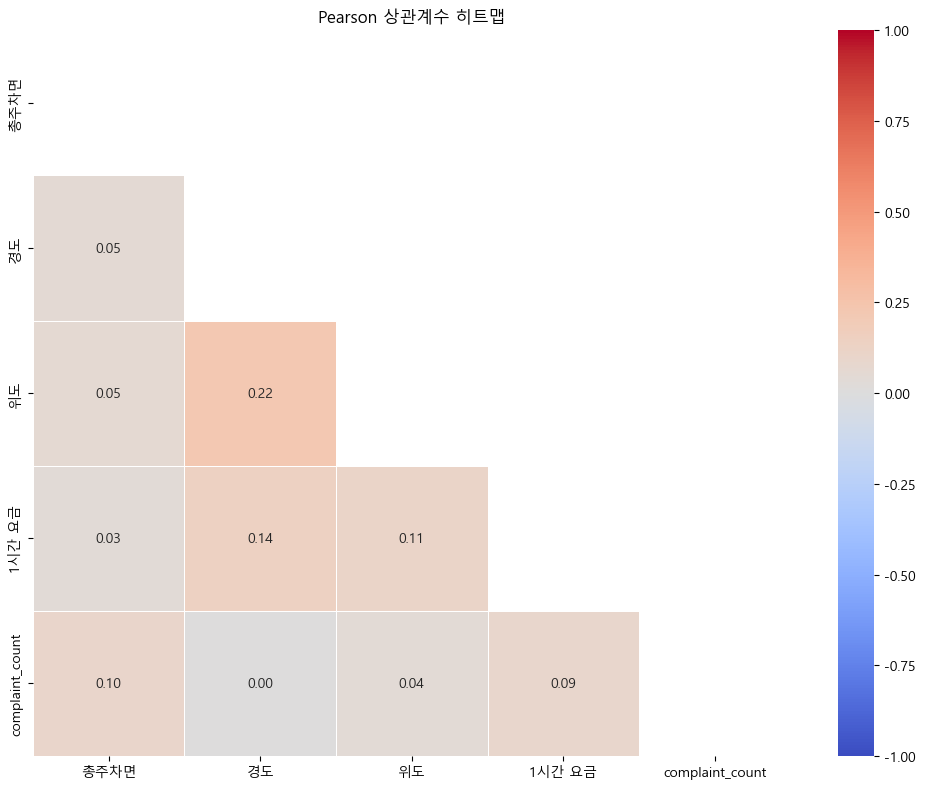

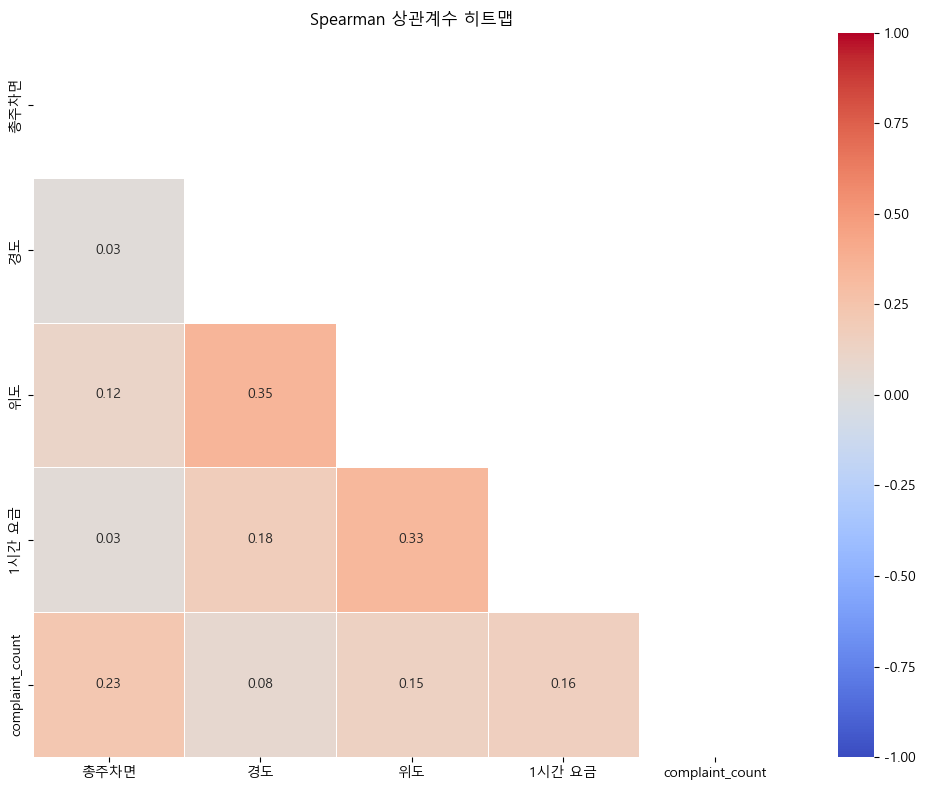

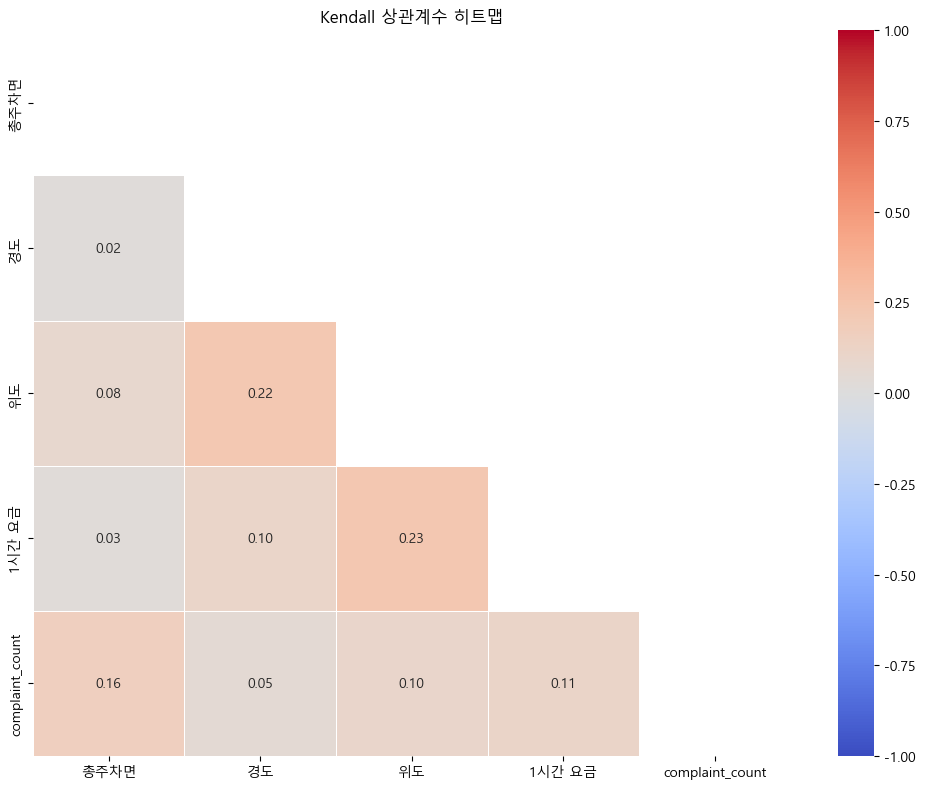

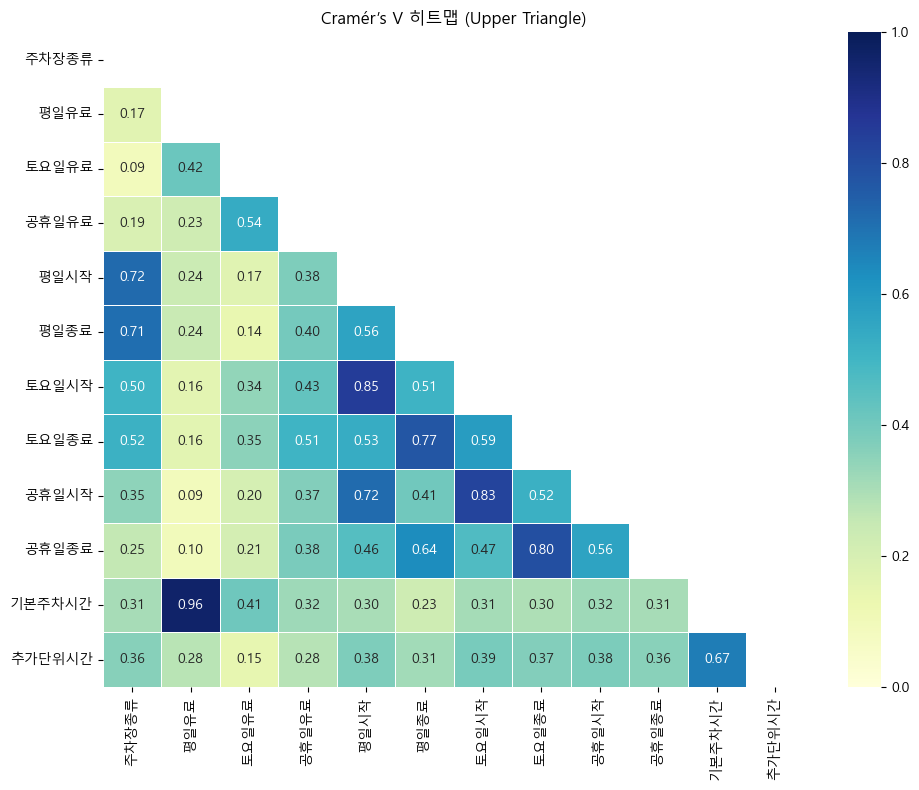

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats.contingency import association
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import BallTree

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 상수
R_EARTH = 6_371_000  # 지구 반지름 (m)
THRESHOLD = 20       # numeric 고유값 기준 임계치

# 1) 데이터 로드 및 좌표 전처리
parks   = pd.read_csv('parks.csv')
reports = pd.read_csv('reports.csv')

parks_clean = parks.dropna(subset=['위도','경도']).reset_index(drop=True)
reports_clean = reports.dropna(subset=['위도','경도']).reset_index(drop=True)

# 2) BallTree 생성 (라디안 단위, haversine)
park_rad   = np.radians(parks_clean[['위도','경도']].values)
tree       = BallTree(park_rad, metric='haversine')

report_rad = np.radians(reports_clean[['위도','경도']].values)
dist, idx  = tree.query(report_rad, k=1)  # 가장 가까운 주차장 인덱스

# (선택) 너무 먼 민원은 제외하고 싶으면 dist를 이용해 필터링 가능
max_dist = 500 / R_EARTH  # 예: 500m 이내만
mask = dist.flatten() <= max_dist
reports_clean = reports_clean.loc[mask]
idx = idx[mask]

reports_clean['park_idx'] = idx.flatten()

# 3) 주차장별 민원 건수 집계
complaints = reports_clean.groupby('park_idx').size().rename('complaint_count')
parks_clean = parks_clean.merge(
    complaints, left_index=True, right_index=True, how='left'
).fillna({'complaint_count':0})
parks_clean['complaint_count'] = parks_clean['complaint_count'].astype(int)

# 4) 자동으로 연속형 vs 범주형 분류
continuous_cols = []
categorical_cols = []
id_cols = ['park_idx', 'complaint_count', '주소','기본주차요금','추가단위요금','운영구분명']  # 분석에서 제외할 컬럼

for col in parks_clean.columns:
    if col in id_cols:
        continue
    if is_numeric_dtype(parks_clean[col]):
        if parks_clean[col].nunique() < THRESHOLD:
            categorical_cols.append(col)
        else:
            continuous_cols.append(col)
    else:
        categorical_cols.append(col)

print("연속형 변수:", continuous_cols)
print("범주형 변수:", categorical_cols)

# 5) 범주형 → 수치 인코딩
df_enc = parks_clean.copy()
for col in categorical_cols:
    df_enc[col] = df_enc[col].astype('category').cat.codes

# 6) 연속형 vs 연속형 상관계수
pearson  = df_enc[continuous_cols + ['complaint_count']].corr(method='pearson')
spearman = df_enc[continuous_cols + ['complaint_count']].corr(method='spearman')
kendall  = df_enc[continuous_cols + ['complaint_count']].corr(method='kendall')

print("\n■ Pearson\n", pearson.round(3))
print("\n■ Spearman\n", spearman.round(3))
print("\n■ Kendall\n", kendall.round(3))

# 7) 이분범주형 vs 연속형 (Point-Biserial)
for col in categorical_cols:
    if df_enc[col].nunique() == 2:
        r_pb, p_pb = pointbiserialr(df_enc[col], df_enc['complaint_count'])
        print(f"\nPoint-Biserial ({col} vs complaint_count): r={r_pb:.3f}, p={p_pb:.3f}")

# 8) 범주형 vs 범주형 (Cramér’s V)
for i, c1 in enumerate(categorical_cols):
    for c2 in categorical_cols[i+1:]:
        ct = pd.crosstab(df_enc[c1], df_enc[c2])
        if ct.size > 1:
            v = association(ct.values, method='cramer')
            print(f"Cramér’s V ({c1} vs {c2}): {v:.3f}")


# 9) 상관계수 히트맵 함수 정의
def plot_corr_heatmap(df_corr, title):
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    plt.figure(figsize=(10,8))
    sns.heatmap(
        df_corr, annot=True, fmt=".2f", cmap='coolwarm', 
        vmin=-1, vmax=1, mask=mask, linewidths=0.5
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 10) Pearson / Spearman / Kendall 히트맵
plot_corr_heatmap(pearson,  "Pearson 상관계수 히트맵")
plot_corr_heatmap(spearman, "Spearman 상관계수 히트맵")
plot_corr_heatmap(kendall,  "Kendall 상관계수 히트맵")

# 11) Cramér’s V 히트맵 (범주형 변수 전용)
#    categorical_cols 에 담긴 컬럼들 간의 Cramér’s V 계산
n_cat = len(categorical_cols)
cramer_mat = pd.DataFrame(
    np.eye(n_cat),
    index=categorical_cols,
    columns=categorical_cols
)
for i, c1 in enumerate(categorical_cols):
    for j, c2 in enumerate(categorical_cols):
        if i < j:
            ct = pd.crosstab(df_enc[c1], df_enc[c2])
            cramer_mat.loc[c1, c2] = cramer_mat.loc[c2, c1] = association(ct.values, method='cramer')

# 상단 삼각형 마스크 생성
mask_cramer = np.triu(np.ones_like(cramer_mat, dtype=bool))

# 히트맵 그리기
plt.figure(figsize=(10,8))
sns.heatmap(
    cramer_mat,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    vmin=0, vmax=1,
    mask=mask_cramer,
    linewidths=0.5
)
plt.title("Cramér’s V 히트맵 (Upper Triangle)")
plt.tight_layout()
plt.show()